# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Halida Fiadnin
- **Email:** halidaafiadnin@gmail.com
- **ID Dicoding:** halidafi

## Import Semua Packages/Library yang Digunakan

In [21]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import matplotlib.pyplot as plt
import seaborn as sns
import io
from PIL import Image
import imageio
import cv2
from skimage.util import img_as_ubyte
from skimage.transform import AffineTransform, warp, rotate, resize
from skimage.filters import gaussian
from skimage import exposure
from skimage.exposure import adjust_gamma

In [22]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [23]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

In [62]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hldfiadn","key":"5e292f8648fa04f386ce49b697f4e3d6"}'}

In [63]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [64]:
!cat ~/.kaggle/kaggle.json

{"username":"hldfiadn","key":"5e292f8648fa04f386ce49b697f4e3d6"}

In [61]:
"""
import shutil, os

for item in os.listdir():
    if item != 'sample_data':  # biarkan folder default Colab
        try:
            shutil.rmtree(item)  # jika folder
        except NotADirectoryError:
            os.remove(item)     # jika file
"""

"\nimport shutil, os\n\nfor item in os.listdir():\n    if item != 'sample_data':  # biarkan folder default Colab\n        try:\n            shutil.rmtree(item)  # jika folder\n        except NotADirectoryError:\n            os.remove(item)     # jika file\n"

In [65]:
os.listdir()

['kaggle.json', 'sample_data']

### Data Loading

In [66]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1008).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1009).jpg  
  inflating: Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (101).jpg  
  inflating: Shoe 

### Split Dataset

In [67]:
source_dir = 'Shoe vs Sandal vs Boot Dataset'
output_dir = 'ShoeDatasetSplit/dataset'
os.makedirs(output_dir, exist_ok=True)

splits = ['train', 'valid', 'test']
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

for cls in os.listdir(source_dir):
    class_path = os.path.join(source_dir, cls)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_and_valid, test = train_test_split(images, test_size=test_ratio, random_state=42)
    train, valid = train_test_split(train_and_valid, test_size=valid_ratio/(train_ratio + valid_ratio), random_state=42)

    for split_name, split_data in zip(splits, [train, valid, test]):
        split_class_dir = os.path.join('ShoeDatasetSplit', split_name, cls)
        os.makedirs(split_class_dir, exist_ok=True)
        for img_name in split_data:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(split_class_dir, img_name)
            shutil.copy2(src, dst)


### Data Preprocessing (Data Augmentation)

In [68]:
# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

In [69]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down
}

augmented_output_dir = 'ShoeDatasetSplit/train'
images_to_generate = 1000

for cls in os.listdir(augmented_output_dir):
    class_path = os.path.join(augmented_output_dir, cls)
    if not os.path.isdir(class_path):
        continue

    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('jpg','jpeg','png'))]
    i = 1
    while i <= images_to_generate:
        image_path = random.choice(images)
        try:
            original_image = imageio.imread(image_path)
            transformed_image = original_image.copy()
            n = 0
            transformation_count = random.randint(1, len(transformations))

            while n <= transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](transformed_image)
                n += 1

            new_image_path = os.path.join(class_path, f"augmented_image_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i += 1
        except Exception as e:
            print(f"Skipping image {image_path} due to error: {e}")

<ipython-input-69-b994d4ca110b>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(image_path)


Streaming output truncated to the last 5000 lines.
>     'depth' is 6 (CV_64F)

Skipping image ShoeDatasetSplit/train/Shoe/Shoe (4241).jpg due to error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)

Skipping image ShoeDatasetSplit/train/Shoe/Shoe (3239).jpg due to error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelp

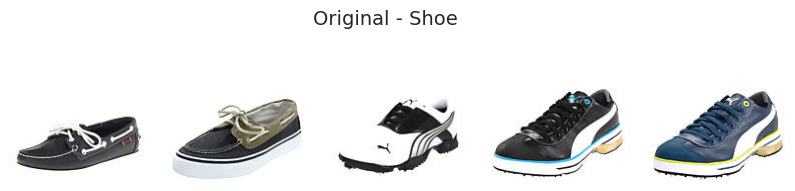

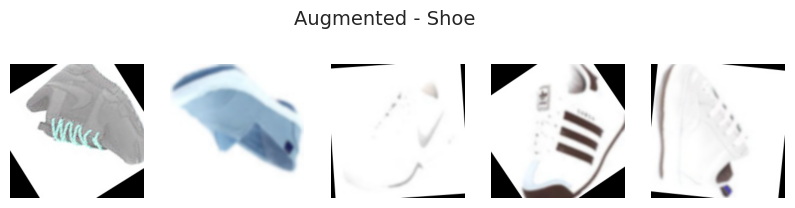

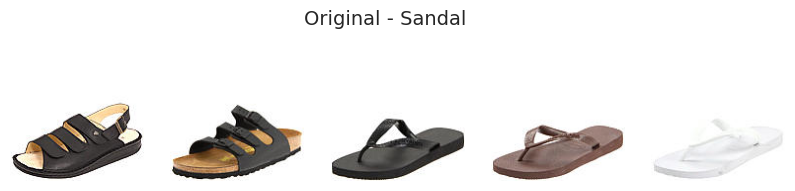

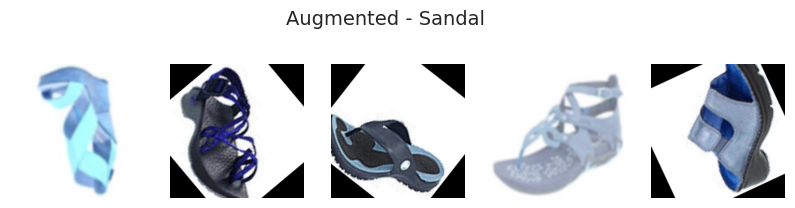

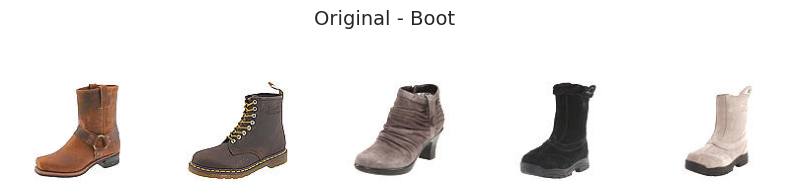

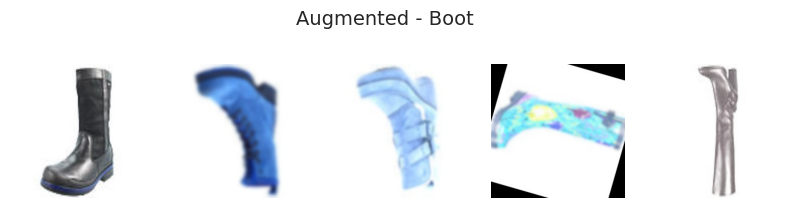

In [75]:
import matplotlib.image as mpimg

def show_image_grid(class_name, folder_path, is_augmented=False, n=5, title=''):
    if is_augmented:
        files = [f for f in os.listdir(folder_path) if f.startswith('augmented_image')]
    else:
        files = [f for f in os.listdir(folder_path) if not f.startswith('augmented_image')]

    files = sorted(files)[:n]
    fig, axes = plt.subplots(1, n, figsize=(n*2, 2.5))
    fig.suptitle(f"{title} - {class_name}", fontsize=14)

    for i, fname in enumerate(files):
        img = mpimg.imread(os.path.join(folder_path, fname))
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Visualisasi gambar asli & augmentasi dari setiap kelas
for cls in ['Shoe', 'Sandal', 'Boot']:
    folder = os.path.join('ShoeDatasetSplit', 'train', cls)
    show_image_grid(cls, folder, is_augmented=False, n=5, title='Original')
    show_image_grid(cls, folder, is_augmented=True, n=5, title='Augmented')

In [80]:
classes = ['Shoe', 'Sandal', 'Boot']
base_dir = 'ShoeDatasetSplit'

# TRAIN
for cls in classes:
    train_path = os.path.join(base_dir, 'train', cls)
    all_train = os.listdir(train_path)
    original_train = [f for f in all_train if not f.startswith('augmented_image') and f.lower().endswith(('jpg','jpeg','png'))]
    augmented_train = [f for f in all_train if f.startswith('augmented_image')]
    print(f"Total number of normal {cls.lower()} images in training set: {len(original_train)}")
    print(f"Total number of augmented {cls.lower()} images in training set: {len(augmented_train)}")
print("\n")

# TEST
for cls in classes:
    test_path = os.path.join(base_dir, 'test', cls)
    test_total = len([f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    print(f"Total number of {cls.lower()} images in test set: {test_total}")
print("\n")

# VALID
for cls in classes:
    valid_path = os.path.join(base_dir, 'valid', cls)
    valid_total = len([f for f in os.listdir(valid_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    print(f"Total number of {cls.lower()} images in valid set: {valid_total}")

Total number of normal shoe images in training set: 3500
Total number of augmented shoe images in training set: 1000
Total number of normal sandal images in training set: 3500
Total number of augmented sandal images in training set: 1000
Total number of normal boot images in training set: 3500
Total number of augmented boot images in training set: 1000


Total number of shoe images in test set: 750
Total number of sandal images in test set: 750
Total number of boot images in test set: 750


Total number of shoe images in valid set: 750
Total number of sandal images in valid set: 750
Total number of boot images in valid set: 750


## Modelling

### Data Splitting

In [51]:
mypath = 'ShoeDatasetSplit/dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    # Filter hanya folder asli (bukan *_augmented)
    if os.path.basename(path).endswith('_augmented'):
        continue

    for name in files:
        if name.lower().endswith(('.jpg', '.jpeg', '.png')):  # hanya file gambar
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # label = nama folder
            file_name.append(name)

# Buat DataFrame
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Tampilkan jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Boot,5000
Sandal,5000
Shoe,5000


In [52]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [53]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [54]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels
test   Boot       951
       Sandal    1062
       Shoe       987
train  Boot      4049
       Sandal    3938
       Shoe      4013
dtype: int64 


                                                    path  labels    set
1460       ShoeDatasetSplit/dataset/Boot/boot (1138).jpg    Boot  train
8976   ShoeDatasetSplit/dataset/Sandal/Sandal (1157).jpg  Sandal  train
11474       ShoeDatasetSplit/dataset/Boot/boot (693).jpg    Boot  train
6658   ShoeDatasetSplit/dataset/Sandal/Sandal (1718).jpg  Sandal  train
12834      ShoeDatasetSplit/dataset/Boot/boot (2996).jpg    Boot   test


In [56]:
# Gabungkan df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli (semua gambar sebelum dipisah train/valid/test)
datasource_path = "ShoeDatasetSplit/dataset/"

# Menentukan folder tempat menyimpan dataset yang telah dibagi (jika ada)
dataset_path = "ShoeDatasetSplit/"  # atau ubah jadi "ShoeDatasetSplitFinal/" jika kamu ingin hasil akhir dipisah



set    labels
test   Boot       951
       Sandal    1062
       Shoe       987
train  Boot      4049
       Sandal    3938
       Shoe      4013
dtype: int64 


                                                    path  labels    set
8388        ShoeDatasetSplit/dataset/Shoe/Shoe (510).jpg    Shoe  train
13917  ShoeDatasetSplit/dataset/Sandal/Sandal (1458).jpg  Sandal   test
9834   ShoeDatasetSplit/dataset/Sandal/Sandal (2554).jpg  Sandal  train
10587       ShoeDatasetSplit/dataset/Shoe/Shoe (869).jpg    Shoe  train
10319  ShoeDatasetSplit/dataset/Sandal/Sandal (3058).jpg  Sandal  train


In [57]:
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    # Ambil path file
    file_path = row['path']

    # Jika file tidak ditemukan (misalnya karena path tidak lengkap), coba bangun ulang
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])

    # Buat direktori tujuan jika belum ada
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_dir, exist_ok=True)

    # Tentukan path tujuan file
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file jika belum ada
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

  0%|          | 0/15000 [00:00<?, ?it/s]

### Image Data Generator

In [58]:
# Definisikan direktori training dan test
TRAIN_DIR = "ShoeDatasetSplit/train/"
TEST_DIR = "ShoeDatasetSplit/test/"

# Path tiap kelas
train_shoe = os.path.join(TRAIN_DIR, 'Shoe')
train_sandal = os.path.join(TRAIN_DIR, 'Sandal')
train_boot = os.path.join(TRAIN_DIR, 'Boot')

test_shoe = os.path.join(TEST_DIR, 'Shoe')
test_sandal = os.path.join(TEST_DIR, 'Sandal')
test_boot = os.path.join(TEST_DIR, 'Boot')

# Cetak jumlah gambar per kelas
print("Total number of Shoe images in training set: ", len(os.listdir(train_shoe)))
print("Total number of Sandal images in training set: ", len(os.listdir(train_sandal)))
print("Total number of Boot images in training set: ", len(os.listdir(train_boot)))
print("Total number of Shoe images in test set: ", len(os.listdir(test_shoe)))
print("Total number of Sandal images in test set: ", len(os.listdir(test_sandal)))
print("Total number of Boot images in test set: ", len(os.listdir(test_boot)))

Total number of Shoe images in training set:  4690
Total number of Sandal images in training set:  4672
Total number of Boot images in training set:  4723
Total number of Shoe images in test set:  1577
Total number of Sandal images in test set:  1662
Total number of Boot images in test set:  1563


In [59]:
# Buat ImageDataGenerator tanpa split karena validasi sudah dipisah folder
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path ke folder hasil split
TRAIN_DIR = "ShoeDatasetSplit/train/"
VALID_DIR = "ShoeDatasetSplit/valid/"
TEST_DIR  = "ShoeDatasetSplit/test/"

# Generator untuk masing-masing set
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150,150),
    color_mode="rgb",  # atau "grayscale" jika kamu yakin datanya hitam putih
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    batch_size=32,
    target_size=(150,150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150,150),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 14085 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 4802 images belonging to 3 classes.


### Pembangunan Model

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)